# PyMEOS Demo for ACM Demo

In [57]:
from functools import partial

import contextily as cx
import pandas as pd
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter, TemporalSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm

tqdm.pandas()
pymeos_initialize()

## Preprocessing

In [139]:
raw = pd.read_csv('singapore_selection.csv', header=0,
                  names=['ID', 'Trajectory ID', 'Driving Mode', 'OS Name', 'Timestamp', 'Latitude', 'Longitude',
                         'Speed', 'Bearing', 'Accuracy'],
                  usecols=['ID', 'Trajectory ID', 'Timestamp', 'Latitude', 'Longitude', 'Speed', 'Bearing', 'Accuracy'])
raw.head()

ID  Trajectory ID   Timestamp  Latitude   Longitude      Speed  \
0          0          70014  1554943236  1.342326  103.888969  18.910000   
1          1          73573  1555582623  1.321781  103.856366  17.719076   
2          2          75567  1555141026  1.327088  103.861273  14.021548   
3          3           1410  1555731693  1.262482  103.823794  13.026521   
4          4           4354  1555584497  1.283799  103.807210  14.812943   
...      ...            ...         ...       ...         ...        ...   
11981  15835          41716  1555689991  1.358511  103.853719  17.430000   
11982  15836           4354  1555582877  1.340595  103.709516   4.696199   
11983  15840          64213  1555377475  1.345842  103.859604  15.760000   
11984  15845          64125  1555849417  1.394273  103.818754  21.950000   
11985  15846           4135  1555044772  1.342483  103.803123  23.599236   

       Bearing  Accuracy  
0          248       3.9  
1           44       4.0  
2           34       3.9  
3          181       4.0  
4           93       3.9  
...        ...       ...  
11981      331       9.0  
11982      160       3.9  
11983      159       3.9  
11984      286       3.9  
11985      136       4.0  

[11986 rows x 8 columns]

In [140]:
raw['Trajectory ID'].nunique()

100

We preprocess the row data so that:
- Rows that have null values are deleted.
- Timestamps are converted from millis since epoch to `datetime` objects.
- A new column with Shapely Points is generated.
- Points are transformed from EPSG:4326 to EPSG:3414

In [32]:
raw = raw.dropna()
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'], origin='unix', unit='s')
raw['Location'] = shp.points(raw['Longitude'], raw['Latitude'])
raw.head()

ID  Trajectory ID           Timestamp  Latitude   Longitude      Speed  \
0   0          70014 2019-04-11 00:40:36  1.342326  103.888969  18.910000   
1   1          73573 2019-04-18 10:17:03  1.321781  103.856366  17.719076   
2   2          75567 2019-04-13 07:37:06  1.327088  103.861273  14.021548   
3   3           1410 2019-04-20 03:41:33  1.262482  103.823794  13.026521   
4   4           4354 2019-04-18 10:48:17  1.283799  103.807210  14.812943   

   Bearing  Accuracy                       Location  
0      248       3.9   POINT (103.888969 1.3423256)  
1       44       4.0  POINT (103.8563664 1.3217811)  
2       34       3.9  POINT (103.8612733 1.3270883)  
3      181       4.0  POINT (103.8237941 1.2624821)  
4       93       3.9   POINT (103.8072101 1.283799)

In [56]:
wgs84 = pyproj.CRS('EPSG:4326')
svy21 = pyproj.CRS('EPSG:3414')

project = partial(transform, pyproj.Transformer.from_crs(wgs84, svy21, always_xy=True).transform)

raw['Location'] = raw['Location'].map(project)
raw.head()

ID  Trajectory ID           Timestamp  Latitude   Longitude      Speed  \
0   0          70014 2019-04-11 00:40:36  1.342326  103.888969  18.910000   
1   1          73573 2019-04-18 10:17:03  1.321781  103.856366  17.719076   
2   2          75567 2019-04-13 07:37:06  1.327088  103.861273  14.021548   
3   3           1410 2019-04-20 03:41:33  1.262482  103.823794  13.026521   
4   4           4354 2019-04-18 10:48:17  1.283799  103.807210  14.812943   

   Bearing  Accuracy                                       Location  
0      248       3.9    POINT (34193.28884111905 36053.13149951502)  
1       44       4.0   POINT (30564.99363142349 33781.367426346194)  
2       34       3.9   POINT (31111.076307488558 34368.21604473356)  
3      181       4.0   POINT (26939.99544875286 27224.380019454307)  
4       93       3.9  POINT (25094.341940912695 29581.505386669698)

## PyMEOS objects generation
Now, we use the original dataset to build the PyMEOS temporal objects.

In [57]:
trajectories = raw[['Trajectory ID', 'Timestamp']].copy()

We start by generating an instant object (`TFloatInst` and `TGeomPointInst`) from the original data

In [58]:
trajectories['Speed'] = raw.progress_apply(lambda row: TFloatInst(value=row['Speed'], timestamp=row['Timestamp']),
                                           axis=1)
trajectories['Bearing'] = raw.progress_apply(lambda row: TFloatInst(value=row['Bearing'], timestamp=row['Timestamp']),
                                             axis=1)
trajectories['Location'] = raw.progress_apply(
    lambda row: TGeomPointInst(point=row['Location'], timestamp=row['Timestamp']), axis=1)
trajectories.head()

  0%|          | 0/11986 [00:00<?, ?it/s]

  0%|          | 0/11986 [00:00<?, ?it/s]

  0%|          | 0/11986 [00:00<?, ?it/s]

Trajectory ID           Timestamp                      Speed  \
0          70014 2019-04-11 00:40:36  18@2019-04-11 00:40:36+02   
1          73573 2019-04-18 10:17:03  17@2019-04-18 10:17:03+02   
2          75567 2019-04-13 07:37:06  14@2019-04-13 07:37:06+02   
3           1410 2019-04-20 03:41:33  13@2019-04-20 03:41:33+02   
4           4354 2019-04-18 10:48:17  14@2019-04-18 10:48:17+02   

                      Bearing  \
0  248@2019-04-11 00:40:36+02   
1   44@2019-04-18 10:17:03+02   
2   34@2019-04-13 07:37:06+02   
3  181@2019-04-20 03:41:33+02   
4   93@2019-04-18 10:48:17+02   

                                            Location  
0  010100000002BB2F3E29B2E0408E783E35A49AE140@201...  
1  01010000000B41A8973FD9DD4093E5F4C1AB7EE040@201...  
2  0101000000F3CD38E2C461DE4024A5D6E906C8E040@201...  
3  010100000098AF6EB5FF4EDA40061E3D521896DA40@201...  
4  01010000004C235CE29581D8408C54415860E3DC40@201...

In [59]:
t = trajectories[['Trajectory ID', 'Timestamp']].copy()
t['Speed'] = trajectories['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = trajectories['Bearing'].map(lambda x: x.as_hexwkb())
t['Location'] = trajectories['Location'].map(lambda x: x.as_hexwkb())
t.to_csv('singapore_instants.csv', index=False)

In [60]:
trajectories = pd.read_csv('singapore_instants.csv', parse_dates=['Timestamp'], converters={
    'Speed': TFloatInst.from_hexwkb,
    'Bearing': TFloatInst.from_hexwkb,
    'Location': TGeomPointInst.from_hexwkb
})
trajectories.head()

Trajectory ID           Timestamp                      Speed  \
0          70014 2019-04-11 00:40:36  18@2019-04-11 00:40:36+02   
1          73573 2019-04-18 10:17:03  17@2019-04-18 10:17:03+02   
2          75567 2019-04-13 07:37:06  14@2019-04-13 07:37:06+02   
3           1410 2019-04-20 03:41:33  13@2019-04-20 03:41:33+02   
4           4354 2019-04-18 10:48:17  14@2019-04-18 10:48:17+02   

                      Bearing  \
0  248@2019-04-11 00:40:36+02   
1   44@2019-04-18 10:17:03+02   
2   34@2019-04-13 07:37:06+02   
3  181@2019-04-20 03:41:33+02   
4   93@2019-04-18 10:48:17+02   

                                            Location  
0  010100000002BB2F3E29B2E0408E783E35A49AE140@201...  
1  01010000000B41A8973FD9DD4093E5F4C1AB7EE040@201...  
2  0101000000F3CD38E2C461DE4024A5D6E906C8E040@201...  
3  010100000098AF6EB5FF4EDA40061E3D521896DA40@201...  
4  01010000004C235CE29581D8408C54415860E3DC40@201...

Now, we sort the rows by time, and aggregate them by Trajectory ID, aggregating the columns in lists

In [61]:
trajectories = trajectories.sort_values(by='Timestamp').groupby('Trajectory ID').agg(list)
trajectories.head()

Timestamp  \
Trajectory ID                                                      
465            [2019-04-10 00:19:35, 2019-04-10 00:19:50, 201...   
747            [2019-04-21 00:36:03, 2019-04-21 00:36:12, 201...   
762            [2019-04-12 09:09:17, 2019-04-12 09:09:25, 201...   
919            [2019-04-21 03:33:50, 2019-04-21 03:34:13, 201...   
956            [2019-04-20 03:28:16, 2019-04-20 03:28:19, 201...   

                                                           Speed  \
Trajectory ID                                                      
465            [15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...   
747            [9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...   
762            [15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...   
919            [9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...   
956            [1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...   

                                                         Bearing  \
Trajectory ID                                                      
465            [23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...   
747            [56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...   
762            [210@2019-04-12 09:09:17+02, 207@2019-04-12 09...   
919            [194@2019-04-21 03:33:50+02, 178@2019-04-21 03...   
956            [62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...   

                                                        Location  
Trajectory ID                                                     
465            [0101000000A7CC287112BAD74042FB30041D55DE40@20...  
747            [0101000000B86DA12F32BBD140497C59449FC6E340@20...  
762            [01010000006B149D8A48E2DA40B89C65917E2FE540@20...  
919            [010100000093056260A51FDD403E85DDE64B05E640@20...  
956            [0101000000277477F48CA8DC40483383EDD6B8E640@20...

Finally, instants are merged into PyMEOS Sequences

In [62]:
trajectories['Speed'] = trajectories['Speed'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Bearing'] = trajectories['Bearing'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Trajectory'] = trajectories['Location'].progress_apply(
    lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(25832))
trajectories = trajectories.drop(['Location', 'Timestamp'], axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [63]:
t = trajectories[['Speed', 'Bearing', 'Trajectory']].copy()
t['Speed'] = t['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].map(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].map(lambda x: x.as_hexwkb())
t.to_csv('singapore_trajectories.csv')

## Extracting interesting trips

In [60]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed  \
Trajectory ID                                                      
465            [15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...   
747            [9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...   
762            [15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...   
919            [9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...   
956            [1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...   

                                                         Bearing  \
Trajectory ID                                                      
465            [23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...   
747            [56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...   
762            [210@2019-04-12 09:09:17+02, 207@2019-04-12 09...   
919            [194@2019-04-21 03:33:50+02, 178@2019-04-21 03...   
956            [62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...   

                                                      Trajectory  
Trajectory ID                                                     
465            [POINT(24296.288156699997 31060.45338081872)@2...  
747            [POINT(18156.78415713992 40500.977093451256)@2...  
762            [POINT(27529.133460302295 43387.95524864778)@2...  
919            [POINT(29822.584007745212 45098.37193180107)@2...  
956            [POINT(29346.20242105811 46534.71649322525)@20...

We now plot the trajectories in a map to take an overall look at them.

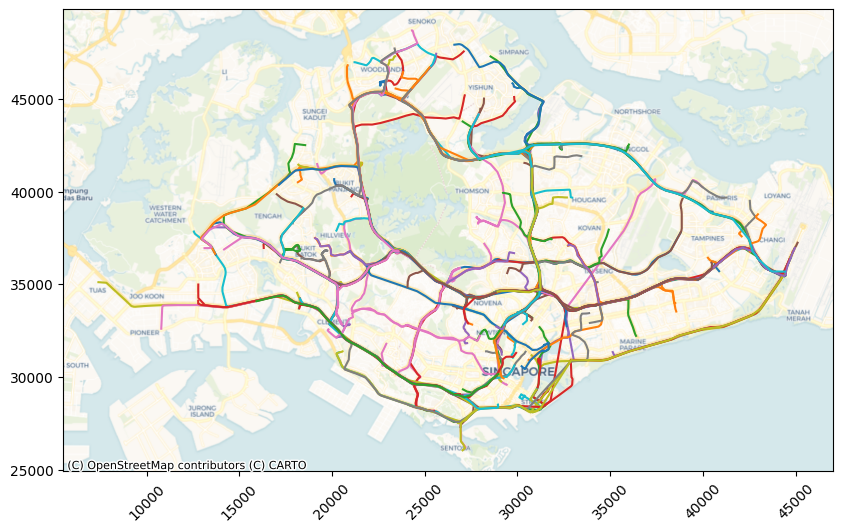

In [61]:
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In this demo we will work over the ferries that do the route Rodby (Denmark) <-> Puttgarden (Germany), so we'll start creating a bounding box for each port.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the ferries.

In [62]:
# TODO: Change text above
bay = shp.set_srid(shp.Point(32232.5740, 30189.7942), 3414)
airport = shp.set_srid(shp.Point(44452.1091, 35088.7227), 3414)

bay_bb = STBox.from_geometry_time(bay, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(1000)
airport_bb = STBox.from_geometry_time(airport, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(
    1000)

joined_bb = bay_bb.expand(airport_bb).expand(100)

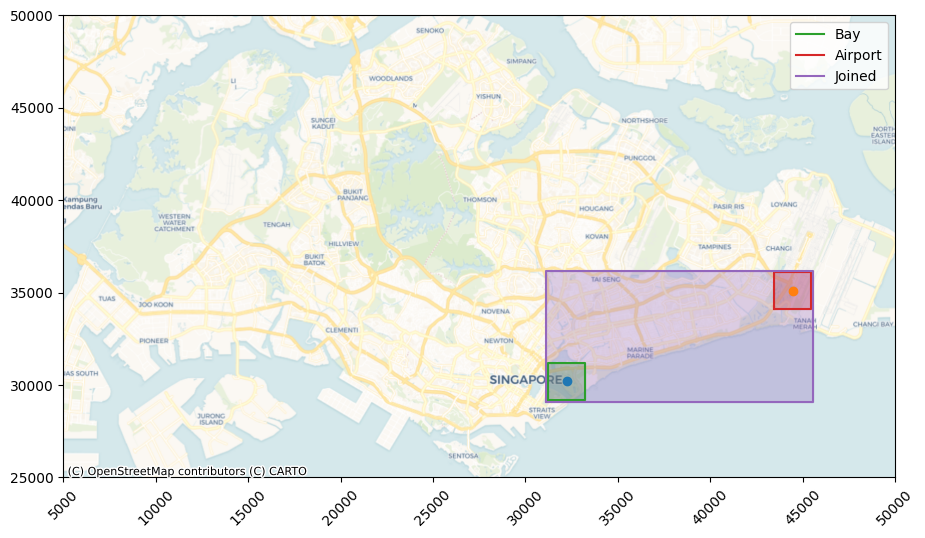

In [63]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(25000, 50000)
ax.set_xlim(5000, 50000)
_ = ax.plot(bay.x, bay.y, marker="o")
_ = ax.plot(airport.x, airport.y, marker="o")
_ = bay_bb.plot_xy(axes=ax, label='Bay')
_ = airport_bb.plot_xy(axes=ax, label='Airport')
_ = joined_bb.plot_xy(axes=ax, label='Joined')
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)
_ = plt.legend()

In [64]:
intersect_index = trajectories['Trajectory'].progress_map(lambda trip: trip.ever_intersects(joined_bb))
possible_trips = trajectories[intersect_index]
external_trips = trajectories[~intersect_index]

  0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
trips_index = possible_trips['Trajectory'].progress_map(lambda trip: trip.ever_intersects(bay_bb)
                                                                     and trip.ever_intersects(airport_bb))
trips = possible_trips[trips_index]
non_trips_internal = possible_trips[~trips_index]

  0%|          | 0/62 [00:00<?, ?it/s]

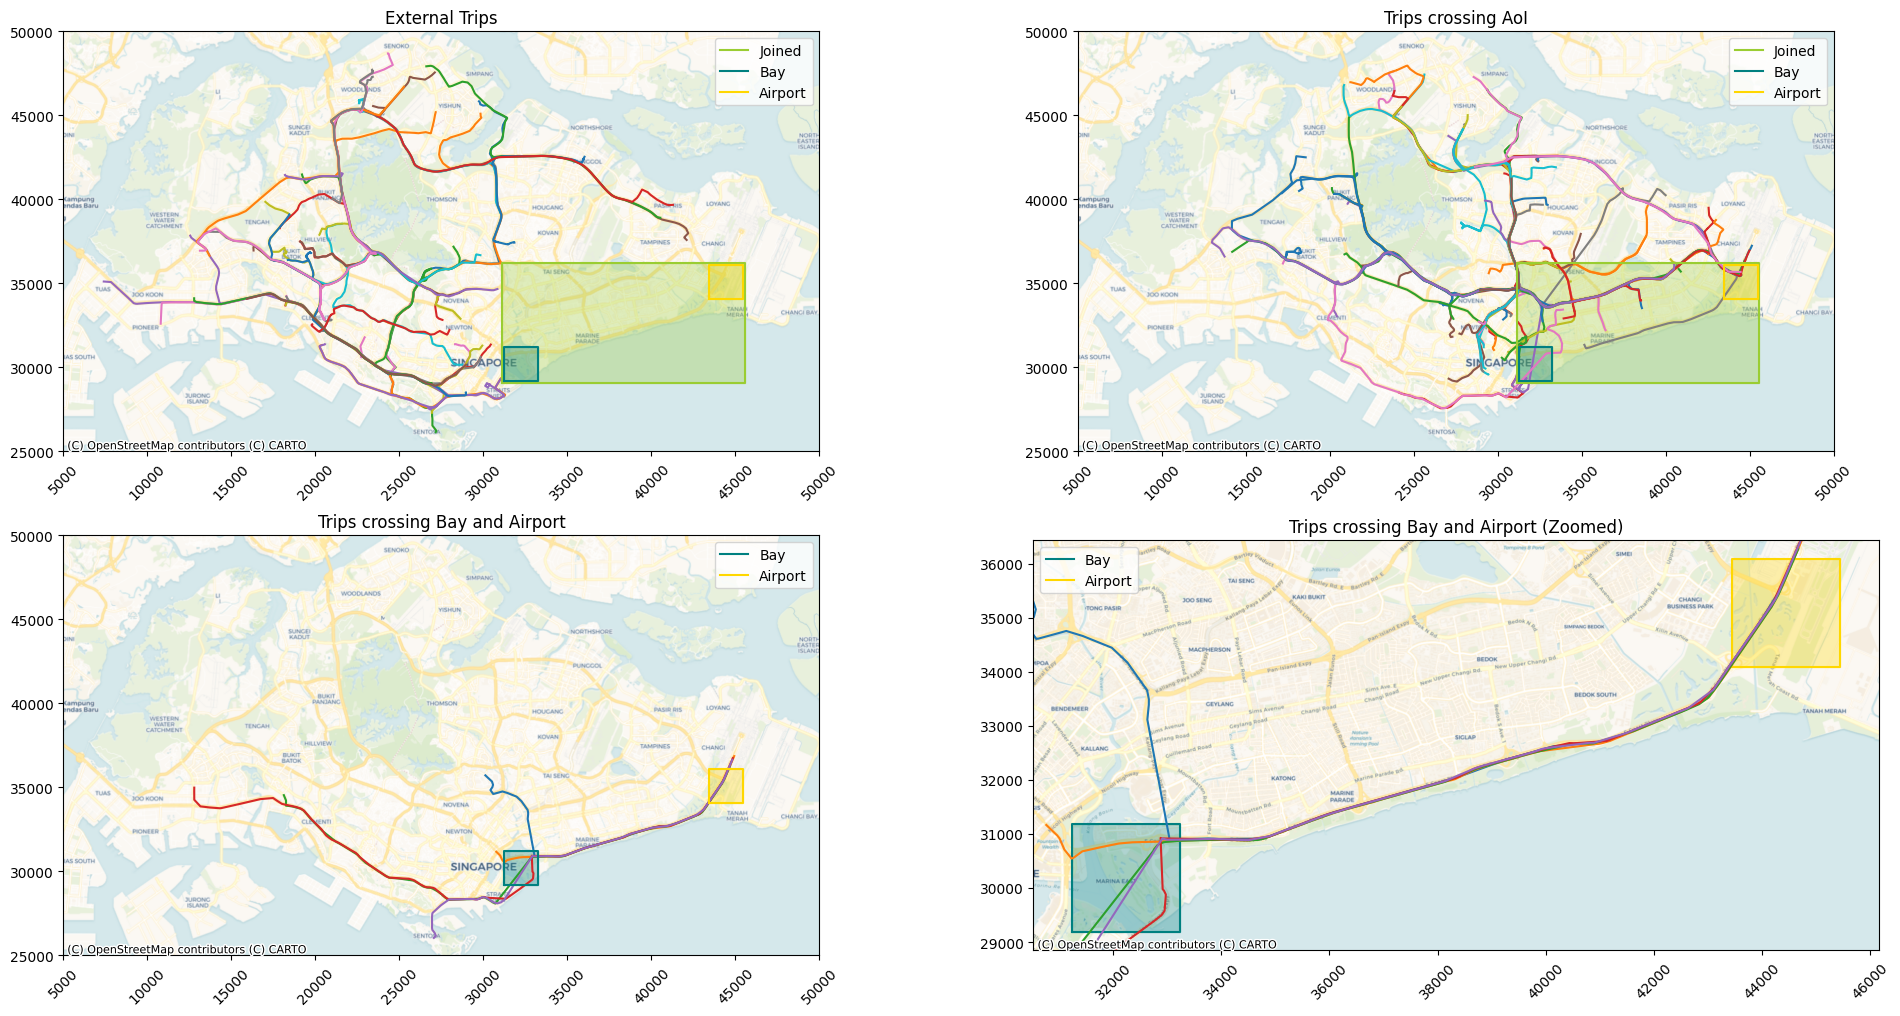

In [66]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(non_trips_internal['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing AoI')
ax[1][0].set_title('Trips crossing Bay and Airport')
ax[1][1].set_title('Trips crossing Bay and Airport (Zoomed)')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for a in [ax[0][0], ax[0][1], ax[1][0]]:
    _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
    _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
    _ = a.set_ylim(25000, 50000)
    _ = a.set_xlim(5000, 50000)
    _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
    _ = a.legend()
_ = bay_bb.plot_xy(axes=ax[1][1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1][1], color='gold', label='Airport')
_ = cx.add_basemap(ax[1][1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
_ = plt.legend()

In [67]:
t = trips.copy()
t['Speed'] = t['Speed'].apply(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].apply(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].apply(lambda x: x.as_hexwkb())
t.to_csv('trips.csv')

nt = pd.concat([
    external_trips.copy(),
    non_trips_internal.copy(),
])
nt['Speed'] = nt['Speed'].apply(lambda x: x.as_hexwkb())
nt['Bearing'] = nt['Bearing'].apply(lambda x: x.as_hexwkb())
nt['Trajectory'] = nt['Trajectory'].apply(lambda x: x.as_hexwkb())
nt.to_csv('non_trips.csv')

## Splitting trajectories into one-leg trips

In [68]:
trips = pd.read_csv('trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
non_trips = pd.read_csv('non_trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trips.head()

Speed  \
Trajectory ID                                                      
9567           [3@2019-04-09 15:16:17+02, 11@2019-04-09 15:16...   
16970          [6@2019-04-13 14:38:02+02, 10@2019-04-13 14:38...   
28962          [16@2019-04-19 09:13:57+02, 15@2019-04-19 09:1...   
64228          [18@2019-04-21 02:23:49+02, 20@2019-04-21 02:2...   
71340          [5@2019-04-11 02:22:48+02, 8@2019-04-11 02:22:...   

                                                         Bearing  \
Trajectory ID                                                      
9567           [130@2019-04-09 15:16:17+02, 127@2019-04-09 15...   
16970          [202@2019-04-13 14:38:02+02, 204@2019-04-13 14...   
28962          [203@2019-04-19 09:13:57+02, 203@2019-04-19 09...   
64228          [179@2019-04-21 02:23:49+02, 179@2019-04-21 02...   
71340          [40@2019-04-11 02:22:48+02, 42@2019-04-11 02:2...   

                                                      Trajectory  
Trajectory ID                                                     
9567           [POINT(30112.63538726141 35716.351383789755)@2...  
16970          [POINT(44924.7669522464 36862.631976138386)@20...  
28962          [POINT(44672.69148016912 36270.46498776914)@20...  
64228          [POINT(12784.925305606452 34982.92848342229)@2...  
71340          [POINT(27044.447152310182 26038.125867060844)@...

In [83]:
geometry_trips = trips.copy()
geometry_trips['Is Inside'] = geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)))
geometry_trips['Time Inside'] = geometry_trips['Is Inside'].map(lambda t: t.when_true())
geometry_trips['Period'] = geometry_trips['Time Inside'].map(lambda t: t.when_true().to_period())
geometry_trips['Time Outside'] = geometry_trips.apply(lambda row: row['Is Inside'].at(row['Period']).when_false(), axis=1)
geometry_trips['Single Trips'] = geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)
geometry_trips.head()

Speed  \
Trajectory ID                                                      
9567           [3@2019-04-09 15:16:17+02, 11@2019-04-09 15:16...   
16970          [6@2019-04-13 14:38:02+02, 10@2019-04-13 14:38...   
28962          [16@2019-04-19 09:13:57+02, 15@2019-04-19 09:1...   
64228          [18@2019-04-21 02:23:49+02, 20@2019-04-21 02:2...   
71340          [5@2019-04-11 02:22:48+02, 8@2019-04-11 02:22:...   

                                                         Bearing  \
Trajectory ID                                                      
9567           [130@2019-04-09 15:16:17+02, 127@2019-04-09 15...   
16970          [202@2019-04-13 14:38:02+02, 204@2019-04-13 14...   
28962          [203@2019-04-19 09:13:57+02, 203@2019-04-19 09...   
64228          [179@2019-04-21 02:23:49+02, 179@2019-04-21 02...   
71340          [40@2019-04-11 02:22:48+02, 42@2019-04-11 02:2...   

                                                      Trajectory  \
Trajectory ID                                                      
9567           [POINT(30112.63538726141 35716.351383789755)@2...   
16970          [POINT(44924.7669522464 36862.631976138386)@20...   
28962          [POINT(44672.69148016912 36270.46498776914)@20...   
64228          [POINT(12784.925305606452 34982.92848342229)@2...   
71340          [POINT(27044.447152310182 26038.125867060844)@...   

                                                       Is Inside  \
Trajectory ID                                                      
9567           {[f@2019-04-09 15:16:17+02, f@2019-04-09 15:21...   
16970          {[f@2019-04-13 14:38:02+02, f@2019-04-13 14:39...   
28962          {[f@2019-04-19 09:13:57+02, f@2019-04-19 09:14...   
64228          {[f@2019-04-21 02:23:49+02, f@2019-04-21 02:41...   
71340          {[f@2019-04-11 02:22:48+02, f@2019-04-11 02:30...   

                                                          Period  \
Trajectory ID                                                      
9567           (2019-04-09 15:21:56.267937+02, 2019-04-09 15:...   
16970          (2019-04-13 14:39:13.685401+02, 2019-04-13 14:...   
28962          (2019-04-19 09:14:08.513408+02, 2019-04-19 09:...   
64228          (2019-04-21 02:41:47.235862+02, 2019-04-21 02:...   
71340          (2019-04-11 02:30:34.121111+02, 2019-04-11 02:...   

                                                    Time Outside  \
Trajectory ID                                                      
9567           {[2019-04-09 15:22:25.819538+02, 2019-04-09 15...   
16970          {[2019-04-13 14:41:04.45163+02, 2019-04-13 14:...   
28962          {[2019-04-19 09:16:11.62326+02, 2019-04-19 09:...   
64228          {[2019-04-21 02:43:53.418866+02, 2019-04-21 02...   
71340          {[2019-04-11 02:33:10.535661+02, 2019-04-11 02...   

                                                    Single Trips  
Trajectory ID                                                     
9567           {[POINT(33232.57399599896 30908.7586717171)@20...  
16970          {[POINT(43452.10911138107 34137.97493371804)@2...  
28962          {[POINT(43452.10911084958 34143.067491071655)@...  
64228          {[POINT(33232.57398648215 30912.187381271444)@...  
71340          {[POINT(33232.57399071607 30894.710346086427)@...

In [79]:
geometry_single_ferry_trips = geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
geometry_single_ferry_trips['Single Trips'] = geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_single_ferry_trips = geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
geometry_single_ferry_trips.insert(0, 'Trip #', geometry_single_ferry_trips.groupby('Trajectory ID').cumcount() + 1)
geometry_single_ferry_trips.head()

Trip #                                               Trip  \
Trajectory ID                                                              
9567                1  [POINT(33232.57399599896 30908.7586717171)@201...   
16970               1  [POINT(43452.10911138107 34137.97493371804)@20...   
28962               1  [POINT(43452.10911084958 34143.067491071655)@2...   
64228               1  [POINT(33232.57398648215 30912.187381271444)@2...   
71340               1  [POINT(33232.57399071607 30894.710346086427)@2...   

                                                           Speed  \
Trajectory ID                                                      
9567           [3@2019-04-09 15:16:17+02, 11@2019-04-09 15:16...   
16970          [6@2019-04-13 14:38:02+02, 10@2019-04-13 14:38...   
28962          [16@2019-04-19 09:13:57+02, 15@2019-04-19 09:1...   
64228          [18@2019-04-21 02:23:49+02, 20@2019-04-21 02:2...   
71340          [5@2019-04-11 02:22:48+02, 8@2019-04-11 02:22:...   

                                                         Bearing  
Trajectory ID                                                     
9567           [130@2019-04-09 15:16:17+02, 127@2019-04-09 15...  
16970          [202@2019-04-13 14:38:02+02, 204@2019-04-13 14...  
28962          [203@2019-04-19 09:13:57+02, 203@2019-04-19 09...  
64228          [179@2019-04-21 02:23:49+02, 179@2019-04-21 02...  
71340          [40@2019-04-11 02:22:48+02, 42@2019-04-11 02:2...

In [80]:
geometry_single_ferry_trips['Speed'] = geometry_single_ferry_trips.apply(
    lambda row: row['Speed'].at(row['Trip'].period()), axis=1)
geometry_single_ferry_trips['Bearing'] = geometry_single_ferry_trips.apply(
    lambda row: row['Bearing'].at(row['Trip'].period()), axis=1)
geometry_single_ferry_trips.head()

Trip #                                               Trip  \
Trajectory ID                                                              
9567                1  [POINT(33232.57399599896 30908.7586717171)@201...   
16970               1  [POINT(43452.10911138107 34137.97493371804)@20...   
28962               1  [POINT(43452.10911084958 34143.067491071655)@2...   
64228               1  [POINT(33232.57398648215 30912.187381271444)@2...   
71340               1  [POINT(33232.57399071607 30894.710346086427)@2...   

                                                           Speed  \
Trajectory ID                                                      
9567           [13.974219714285715@2019-04-09 15:22:25.819538...   
16970          [22@2019-04-13 14:41:04.45163+02, 22@2019-04-1...   
28962          [19@2019-04-19 09:16:11.62326+02, 19@2019-04-1...   
64228          [17.477329107692306@2019-04-21 02:43:53.418866...   
71340          [19.821408076923078@2019-04-11 02:33:10.535661...   

                                                         Bearing  
Trajectory ID                                                     
9567           [27.493554928571427@2019-04-09 15:22:25.819538...  
16970          [213.53916928571428@2019-04-13 14:41:04.45163+...  
28962          [214@2019-04-19 09:16:11.62326+02, 214@2019-04...  
64228          [109.04534178461539@2019-04-21 02:43:53.418866...  
71340          [91.10715515384615@2019-04-11 02:33:10.535661+...

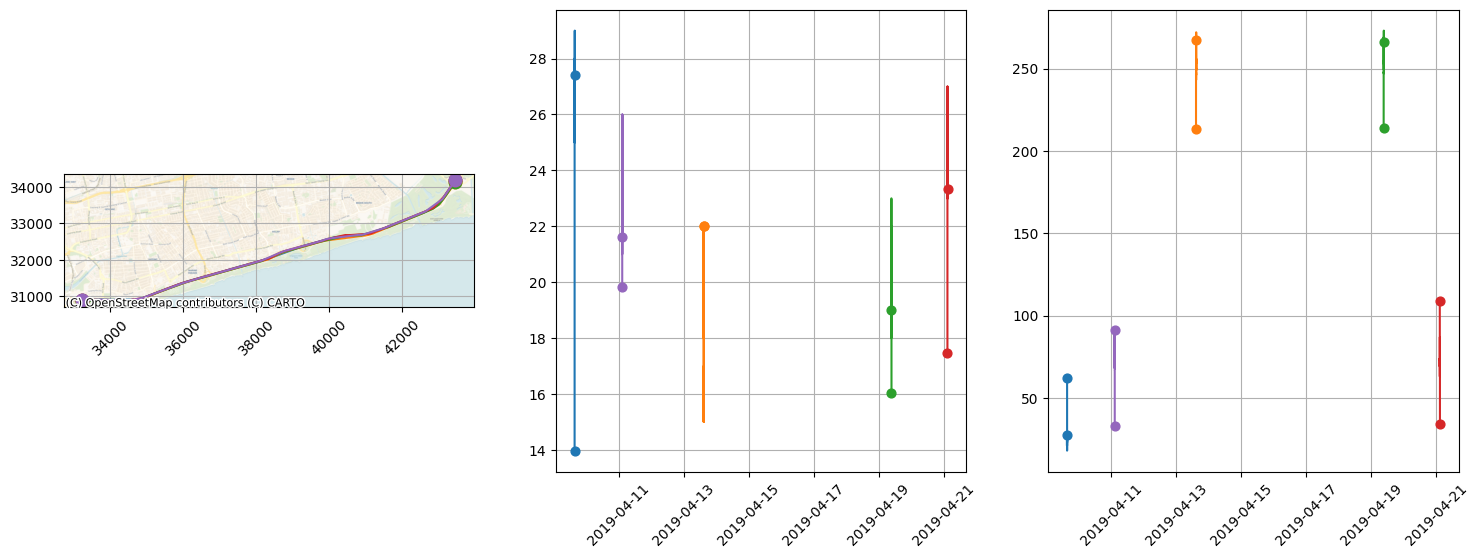

In [81]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)

_ = TemporalSequencePlotter.plot_sequences(geometry_single_ferry_trips['Speed'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences(geometry_single_ferry_trips['Bearing'], axes=ax[2])

In [86]:
old_geometry_trips = trips.copy()
old_geometry_trips['Time Outside'] = old_geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)).when_false())
old_geometry_trips['Single Trips'] = old_geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)

old_geometry_single_ferry_trips = old_geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
old_geometry_single_ferry_trips['Single Trips'] = old_geometry_single_ferry_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
old_geometry_single_ferry_trips = old_geometry_single_ferry_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                                         axis=1)
old_geometry_single_ferry_trips.insert(0, 'Trip #', old_geometry_single_ferry_trips.groupby('Trajectory ID').cumcount() + 1)

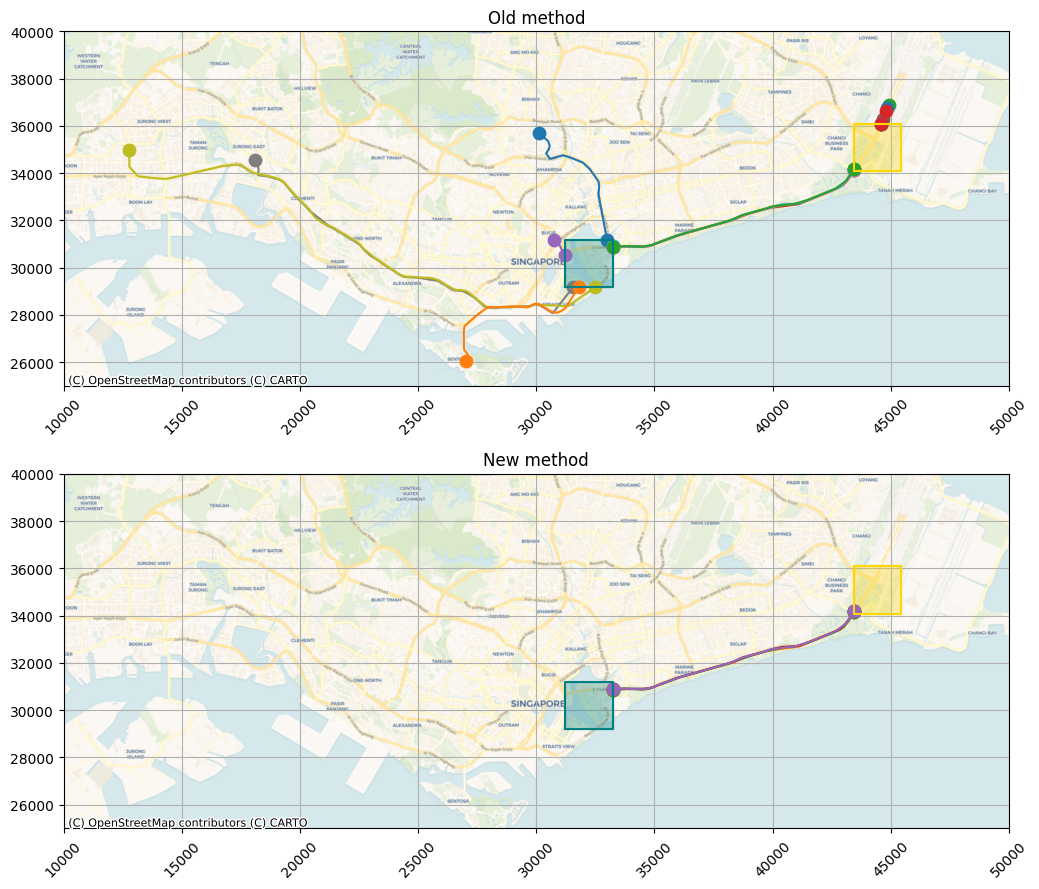

In [92]:
_, ax = plt.subplots(2, 1, figsize=(18, 9))

_ = TemporalPointSequencePlotter.plot_sequences_xy(old_geometry_single_ferry_trips['Trip'], axes=ax[0])
_ = bay_bb.plot_xy(axes=ax[0], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[0], color='gold', label='Airport')
_ = ax[0].set_ylim(25000, 40000)
_ = ax[0].set_xlim(10000, 50000)
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = ax[0].set_title('Old method')

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_single_ferry_trips['Trip'], axes=ax[1])
_ = bay_bb.plot_xy(axes=ax[1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1], color='gold', label='Airport')
_ = ax[1].set_ylim(25000, 40000)
_ = ax[1].set_xlim(10000, 50000)
_ = cx.add_basemap(ax[1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = ax[1].set_title('New method')

plt.tight_layout()

## Trajectory Heatmap

In [93]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed  \
Trajectory ID                                                      
465            [15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...   
747            [9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...   
762            [15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...   
919            [9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...   
956            [1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...   

                                                         Bearing  \
Trajectory ID                                                      
465            [23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...   
747            [56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...   
762            [210@2019-04-12 09:09:17+02, 207@2019-04-12 09...   
919            [194@2019-04-21 03:33:50+02, 178@2019-04-21 03...   
956            [62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...   

                                                      Trajectory  
Trajectory ID                                                     
465            [POINT(24296.288156699997 31060.45338081872)@2...  
747            [POINT(18156.78415713992 40500.977093451256)@2...  
762            [POINT(27529.133460302295 43387.95524864778)@2...  
919            [POINT(29822.584007745212 45098.37193180107)@2...  
956            [POINT(29346.20242105811 46534.71649322525)@20...

In [94]:
bbox: STBox = TemporalPointExtentAggregator.aggregate(trajectories['Trajectory'])

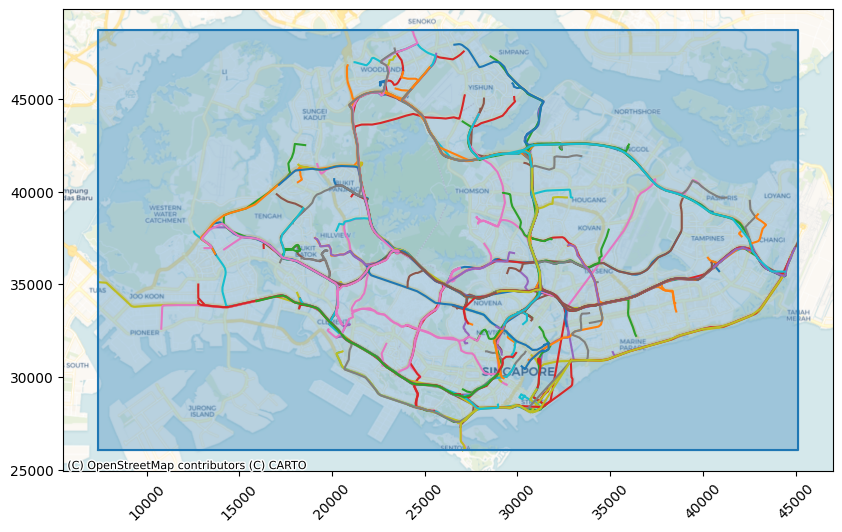

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = bbox.plot_xy(axes=ax)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In [141]:
heat_df = pd.DataFrame(data={'Tile': bbox.tile_flat(size=250)})
heat_df['# Trajectories'] = heat_df['Tile'].map(lambda tile: sum(trajectories['Trajectory'].map(lambda tp: tp.ever_intersects(tile))))
heat_df['X'] = heat_df['Tile'].map(lambda tile: (tile.xmin() + tile.xmax()) / 2)
heat_df['Y'] = heat_df['Tile'].map(lambda tile: (tile.ymin() + tile.ymax()) / 2)
heat_df.head()

Tile  # Trajectories       X  \
0  SRID=3414;STBOX X((7250,26000),(7500,26250))               0  7375.0   
1  SRID=3414;STBOX X((7500,26000),(7750,26250))               0  7625.0   
2  SRID=3414;STBOX X((7750,26000),(8000,26250))               0  7875.0   
3  SRID=3414;STBOX X((8000,26000),(8250,26250))               0  8125.0   
4  SRID=3414;STBOX X((8250,26000),(8500,26250))               0  8375.0   

         Y  
0  26125.0  
1  26125.0  
2  26125.0  
3  26125.0  
4  26125.0

In [142]:
svy21 = pyproj.CRS('EPSG:3414')
wgs84 = pyproj.CRS('EPSG:4326')

project = partial(transform, pyproj.Transformer.from_crs(svy21, wgs84, always_xy=True).transform)

heat_df['Coords'] = pd.Series(shp.points(heat_df['X'], heat_df['Y'])).map(project)
heat_df['Lat'] = heat_df['Coords'].map(lambda p: p.y)
heat_df['Lon'] = heat_df['Coords'].map(lambda p: p.x)
heat_df.head()

Tile  # Trajectories       X  \
0  SRID=3414;STBOX X((7250,26000),(7500,26250))               0  7375.0   
1  SRID=3414;STBOX X((7500,26000),(7750,26250))               0  7625.0   
2  SRID=3414;STBOX X((7750,26000),(8000,26250))               0  7875.0   
3  SRID=3414;STBOX X((8000,26000),(8250,26250))               0  8125.0   
4  SRID=3414;STBOX X((8250,26000),(8500,26250))               0  8375.0   

         Y                                         Coords       Lat  \
0  26125.0  POINT (103.64799739312775 1.2525331133963702)  1.252533   
1  26125.0  POINT (103.65024370279023 1.2525332722921068)  1.252533   
2  26125.0  POINT (103.65249001273617 1.2525334292502786)  1.252533   
3  26125.0   POINT (103.65473632296208 1.252533584270884)  1.252534   
4  26125.0  POINT (103.65698263346448 1.2525337373539227)  1.252534   

          Lon  
0  103.647997  
1  103.650244  
2  103.652490  
3  103.654736  
4  103.656983

In [143]:
import plotly.express as px

fig = px.density_mapbox(heat_df, lat = 'Lat', lon = 'Lon', z = '# Trajectories',
                        radius = 20,
                        zoom = 11,
                        mapbox_style = 'open-street-map',
                        width=1300,
                        height=800,
                        )
fig.show()